## <font color='green'> MNIST - Clustering (Dense Matrix)<font>

### <font color='green'> 1. Description<font>

Clustering using MNIST Digit Recognition dataset.
Dataset is downloaded from tensorflow by using `tensorflow.keras.datasets.mnist.load_data()` method; so please install tensorflow.

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. In this demo we will use this dataset to correctly cluster similar digits.

### <font color='green'> 2. Data Preprocessing<font>

For MNIST Digits dataset we will perform some data preparation and data cleaning steps.

In [1]:
%%capture
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from collections import OrderedDict

In [2]:
def preprocess_data():
    '''
    Load the mnist data and perform pre-processing
    '''
    # Load MNIST Digits dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    x = x.reshape((x.shape[0], -1)).astype('float32')
    x = np.divide(x, 255.)
    return x, y

In [3]:
#---- Data Loading and Preparation ----

X, y = preprocess_data()
n_clusters = len(np.unique(y))
print("Dataset contains {} samples".format(X.shape))
print("Dataset contains {} classes".format(n_clusters))

Dataset contains (70000, 784) samples
Dataset contains 10 classes


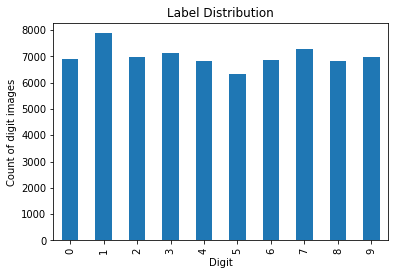

In [4]:
# Label distribution summary
import matplotlib.pyplot as plt
val, count = np.unique(y, return_counts=True)
label = np.asarray((val, count)).T
labels_df = pd.DataFrame(data=label)
ax = labels_df[1].plot(kind='bar', title='Label Distribution').\
     set(xlabel="Digit", ylabel="Count of digit images")

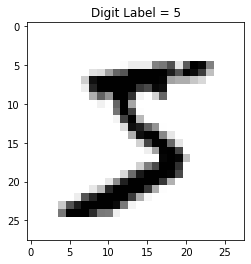

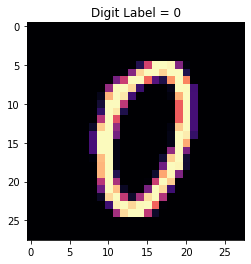

In [5]:
plt.imshow(X[0].reshape(28, 28), cmap = 'binary')
plt.title('Digit Label = {}'.format(y[0]))
plt.show()
plt.imshow(X[1000].reshape(28, 28), cmap = 'magma')
plt.title('Digit Label = {}'.format(y[1000]))
plt.show()

### <font color='green'> 3. Algorithm Evaluation<font>

In [6]:
train_time = []
homogeneity = []
algo = []
ml_framework = []

In [7]:
def evaluate(estimator, algo_nm, framework_nm, X, y):
    '''
    To generate performance report for both frovedis and sklearn estimators
    '''
    algo.append(algo_nm)
    ml_framework.append(framework_nm)
    
    start_time = time.time()
    y_pred = estimator.fit_predict(X)
    train_time.append(round(time.time() - start_time, 4))

    homogeneity.append(metrics.homogeneity_score(y, y_pred))

#### 3.1 KMeans Clustering

In [8]:
#Demo: KMeans Clustering
import frovedis
TARGET = "kmeans"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.cluster import KMeans as frovKM
f_est = frovKM(n_clusters=n_clusters, init='random', algorithm='full', random_state=123, n_init=1)
evaluate(f_est, TARGET, "frov_" + frovedis.__version__, X, y)
f_est.release()
FrovedisServer.shut_down()
print("Frovedis KMeans train time: %.3f sec" % train_time[0])

import sklearn
from sklearn.cluster import KMeans as skKM
s_est = skKM(n_clusters=n_clusters, init='random', algorithm='full', random_state=123, n_init=1)
evaluate(s_est, TARGET, "skl_" + sklearn.__version__, X, y)
print("scikit-learn KMeans train time: %.3f sec" % train_time[1])

Frovedis KMeans train time: 0.493 sec
scikit-learn KMeans train time: 1.696 sec


#### 3.2 Agglomerative Clustering

In [9]:
#Demo: Agglomerative Clustering
import frovedis
TARGET = "agglomerative"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"] )
from frovedis.mllib.cluster import AgglomerativeClustering as frovAgglomerative

# for Agglomerative performed PCA decomposition
from frovedis.mllib.decomposition import PCA
x_pca = PCA(n_components=100).fit_transform(X)

f_est = frovAgglomerative(n_clusters=n_clusters, linkage="average")
evaluate(f_est, TARGET, "frov_" + frovedis.__version__, x_pca, y)
f_est.release()
FrovedisServer.shut_down()
print("Frovedis AgglomerativeClustering train time: %.3f sec" % train_time[2])

import sklearn
from sklearn.cluster import AgglomerativeClustering as skAgglomerative
s_est = skAgglomerative(n_clusters=n_clusters, linkage="average")
evaluate(s_est, TARGET, "skl_" + sklearn.__version__, x_pca, y) 
print("scikit-learn AgglomerativeClustering train time: %.3f sec" % train_time[3])

Frovedis AgglomerativeClustering train time: 16.789 sec
scikit-learn AgglomerativeClustering train time: 300.678 sec


#### 3.3 DBSCAN Clustering

In [10]:
#Demo: DBSCAN Clustering
import frovedis
TARGET = "dbscan"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"] )
from frovedis.mllib.cluster import DBSCAN as frovDB
f_est = frovDB(eps=4.52, metric="euclidean", algorithm="brute")

# we are evaluating DBSCAN with first 50k samples due to memeory issue at Frovedis Server when trying with full data 
evaluate(f_est, TARGET, "frov_" + frovedis.__version__, X[:50000,:], y[:50000])  
f_est.release()
FrovedisServer.shut_down()
print("Frovedis DBSCAN train time: %.3f sec" % train_time[4])

import sklearn
from sklearn.cluster import DBSCAN as skDB
s_est = skDB(eps=4.52, metric="euclidean", algorithm="brute", n_jobs=12)
evaluate(s_est, TARGET, "skl_" + sklearn.__version__, X[:50000,:], y[:50000]) 
print("scikit-learn DBSCAN train time: %.3f sec" % train_time[5])

Frovedis DBSCAN train time: 1.588 sec
scikit-learn DBSCAN train time: 44.054 sec


### <font color='green'> 4. Performance summary<font>

In [11]:
index = pd.MultiIndex.from_tuples(list(zip(algo, ml_framework)), 
                                  names=["algorithm", "ml-framework"])
summary = pd.DataFrame(OrderedDict({ "train time (sec)": train_time, 
                                     "homogeneity_score": homogeneity
                                  }), index=index)
summary

train time (sec)  homogeneity_score
algorithm     ml-framework                                     
kmeans        frov_0.9.10             0.4934           0.490213
              skl_0.24.1              1.6964           0.483556
agglomerative frov_0.9.10            16.7889           0.163916
              skl_0.24.1            300.6783           0.163916
dbscan        frov_0.9.10             1.5884           0.185969
              skl_0.24.1             44.0536           0.185466

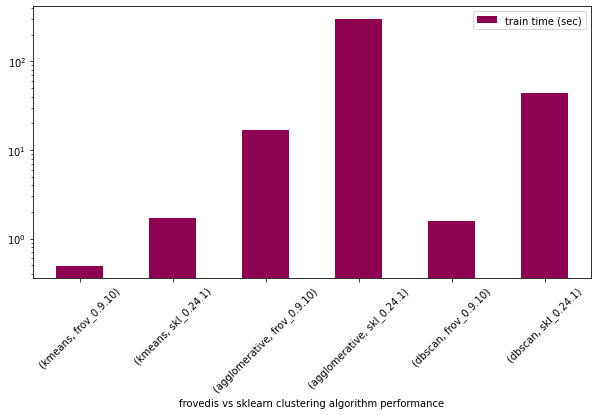

In [12]:
train_graph = summary.plot.bar(y=0, rot=45, figsize=(10,5), log=True, colormap="PiYG", \
                               xlabel="frovedis vs sklearn clustering algorithm performance")

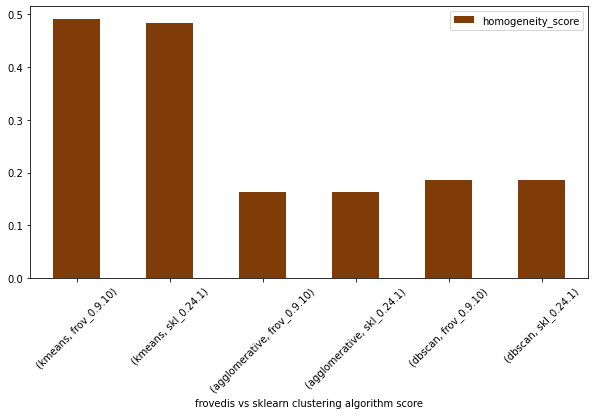

In [13]:
score_graph = summary.plot.bar(y=1, rot=45, figsize=(10,5), colormap="PuOr", \
                              xlabel="frovedis vs sklearn clustering algorithm score")